We implement Spencer's no job left behind algorithm, looking forward an amount of time instead of a number of jobs.

In [1]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time
import numpy as np

In [75]:
lambd = 0.999
mu1 = 0.95
mu2 = 100 # doesn't matter in this case because fast gets kicked out immediately
c = 1
Tmax = 60

p = 1 - mu1
surge_threshold = math.ceil(math.log(p / (1 - lambd), lambd / (1 - p)))
w = 60 # lookahead is online in this case

In [3]:
def log_normal(mu=0, sigma=1):
    return e**(mu+sigma*np.random.normal())

def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    if lambd < 0:
        return inf()
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 999999


def printarray(a): 
    print(np.around(a, 3))
    

# Define customer for the threshold policy
Customer = namedtuple("Customer", "arrival_time")
def customer(arrival_time=-1):
    return Customer(arrival_time=arrival_time)

# Define customer for the w-lookahead policy
# mu1 is the slow service rate and mu2 is the fast service rate
WCustomer = namedtuple("WCustomer", "arrival_time slow_service_time fast_service_time enter_service_time service_time arrival_index fast")
def wcustomer(arrival_time=-1, mu1=-1, mu2=-1, arrival_index=0):
    slow = exp(mu1)
    fast = 0 #slow * mu1/mu2
    return WCustomer(arrival_time=arrival_time, slow_service_time=slow,
                     fast_service_time=fast, enter_service_time=-1,
                     service_time=-1, arrival_index=arrival_index, fast=False)

def wcustomer_slow_fast(arrival_time=-1, slow=2, fast=0, arrival_index=0):
    return WCustomer(arrival_time=arrival_time, slow_service_time=slow,
                     fast_service_time=fast, enter_service_time=-1,
                     service_time=-1, arrival_index=arrival_index, fast=False)

def wcustomer_with_parameters(w, current_time, fast):
    if fast:
        return WCustomer(arrival_time=w.arrival_time, slow_service_time=w.slow_service_time,
                         fast_service_time=w.fast_service_time, enter_service_time=current_time,
                         service_time=current_time+w.fast_service_time,
                         arrival_index=w.arrival_index, fast=True)
    return WCustomer(arrival_time=w.arrival_time, slow_service_time=w.slow_service_time,
                     fast_service_time=w.fast_service_time, enter_service_time=current_time,
                     service_time=current_time+w.slow_service_time,
                     arrival_index=w.arrival_index, fast=False)

def wcustomer_deleted(w):
    return WCustomer(arrival_time=w.arrival_time, slow_service_time=0,
                     fast_service_time=w.fast_service_time, enter_service_time=w.enter_service_time,
                     service_time=w.service_time,
                     arrival_index=w.arrival_index, fast=True)

In [67]:
def gen_arrivals(lambd, mu1, mu2, Tmax): 
    # generate arrivals independent of whether or not we speed up the customers
    T_advance = [0]  # list of events that get generated in advance
    arrivals = []
    while T_advance[-1] < Tmax:
        t_temp = T_advance[-1]
        next_arrival = t_temp + exp(lambd)
        T_advance.append(next_arrival)
        arrivals.append(wcustomer(next_arrival, mu1, mu2, len(T_advance) - 2))
    return arrivals

In [5]:
def gen_deterministic_arrivals(lambd, mu1, mu2, Tmax): 
    # generate arrivals independent of whether or not we speed up the customers
    T_advance = [0]  # list of events that get generated in advance
    arrivals = []
    arrivals.append(wcustomer_slow_fast(0, 2, 0, 0))
    arrivals.append(wcustomer_slow_fast(1, 1, 0, 1))
    arrivals.append(wcustomer_slow_fast(4, 3, 0, 2))
    arrivals.append(wcustomer_slow_fast(5, 1, 0, 3))
    arrivals.append(wcustomer_slow_fast(6, 10, 0, 4))
    arrivals.append(wcustomer_slow_fast(9, 10, 0, 5))
    return arrivals

In [6]:
def gen_deletion_list(T, N):
    deletions = list()
    current_min = N[-1]
    for i in range(len(N) - 2, 0, -1):
        if N[i] < current_min:
            current_min = N[i]
            deletions.append(i + 1)
    return deletions

In [7]:
def execute_deletions(T, N):
    deletions = gen_deletion_list(T, N)
    #print(deletions)
    for i in deletions:
        for j in range(i, len(N)):
            N[j] -= 1
    return T, N, len(deletions) / len(N)

In [108]:
def gen_forward_deletions_2(T, D, w):
    if w > T[-1]:
        w = T[-1]
    
    lookahead = [min(t + w, T[-1]) for t in T]
    print(lookahead)
    done = np.zeros(len(D))
    
    walk_forward_index = 0
    deletion_index = 0
    
    sums_pointer = 0
    sums = np.zeros(len(D))
    
    deletion_count = 0
    deletions = np.zeros(len(D))
    min_lookahead = 0
    
    for i in range(len(D)):
        print("Current time %.2f" % (T[i]))
        this_increase = D[i]
        sums[i] += this_increase
        print(" outside changing at index %d to %d by %d" % (i, sums[i], this_increase))
        if sums[i] < 0:
            done[i] = 1
            print("index %d is done" % (i))
        
        start_loop = min_lookahead
        for j in range(start_loop, i):
            print("index %d current time %.2f time %.2f lookahead time %.2f" % (j, T[i], T[j], lookahead[j]))
            if T[i] < lookahead[j]:
                if done[j] == 0:
                    sums[j] += this_increase
                    print(" inside changing at index %d to %d by %d" % (j, sums[j], this_increase))
                    if sums[j] <= 0:
                        done[j] = 1
                        print("index %d is done" % (j))
            else:
                min_lookahead = j
                print("Update min lookahead to " + str(j))
    
    print(sums)
    print(done)
    
    for i in range(len(sums)):
        if sums[i] > 0 and D[i] == 1:
            print("Delete arrival index %d at time %.2f" % (i, T[i]))
            deletion_count += 1
        deletions[i] = deletion_count
    
    print(deletions)
    
    return deletions

In [109]:

deletions2 = gen_forward_deletions_2(T1.copy(), D1.copy(), 5)

[5, 5.721272639948483, 6.206543310426825, 6.571934718518413, 6.6186183486843175, 6.761058805249412, 6.856912947680971, 6.9300782459801935, 6.962038450425282, 8.34802291603624, 8.93304750598328, 10.421768255962263, 10.520545178997208, 10.571124231638983, 10.999597577522351, 11.22284659525065, 11.5214454766893, 11.671705342162031, 11.812444412603115, 12.586199327927881, 15.132281346662774, 15.45769405754981, 15.75691649987552, 16.00800992498196, 16.621323011192615, 17.904542488597805, 18.404567063860757, 18.408056124864657, 18.81003699279936, 19.156920527100745, 19.533100037933362, 19.93213495899234, 20.865970147792098, 22.55727780016345, 23.045588132782015, 23.45434261804488, 23.472543664909246, 23.98000147225201, 24.448555746711666, 24.80081199832948, 25.194132917287213, 25.781422129436013, 26.617658446201315, 27.169868708589505, 27.303944174041867, 28.725851194090584, 29.881152072381095, 30.913355711728187, 31.067738647338654, 31.956320184691485, 31.980560139996758, 32.348760966745274

In [110]:

deletions4 = gen_forward_deletions_2(T1.copy(), D1.copy(), 0.1)

[0.1, 0.8212726399484828, 1.3065433104268247, 1.671934718518413, 1.7186183486843176, 1.8610588052494124, 1.9569129476809715, 2.0300782459801936, 2.0620384504252818, 3.448022916036239, 4.033047505983281, 5.521768255962264, 5.620545178997208, 5.671124231638983, 6.099597577522352, 6.322846595250649, 6.621445476689299, 6.771705342162031, 6.912444412603115, 7.686199327927881, 10.232281346662774, 10.55769405754981, 10.856916499875519, 11.108009924981959, 11.721323011192613, 13.004542488597805, 13.504567063860756, 13.508056124864659, 13.91003699279936, 14.256920527100743, 14.633100037933362, 15.032134958992339, 15.965970147792097, 17.657277800163452, 18.145588132782017, 18.55434261804488, 18.572543664909247, 19.08000147225201, 19.548555746711667, 19.90081199832948, 20.294132917287214, 20.881422129436015, 21.717658446201316, 22.269868708589506, 22.403944174041868, 23.825851194090585, 24.981152072381096, 26.013355711728188, 26.167738647338656, 27.056320184691486, 27.08056013999676, 27.448760966

In [9]:
def gen_forward_deletions(T, D, w):
    if w > len(D) - 1:
        w = len(D) - 1
    
    walk_forward_index = 0
    deletion_index = 0
    
    sums_pointer = 0
    sums = np.zeros(w)
    
    deletion_count = 0
    deletions = np.zeros(len(D))
    
    print("Initial loop")
    # initial population of sums array
    for i in range(w):
        walk_forward_index = i
        #print(D[walk_forward_index])
        for j in range(0, i + 1):
            if sums[j] > 0:
                sums[j] += D[walk_forward_index]
        sums[i] += D[walk_forward_index]
        #print(sums)
    
    if sums[sums_pointer] > 0 and D[deletion_index] == 1:
        deletion_count += 1
    deletions[deletion_index] = deletion_count
    deletion_index += 1
    sums[sums_pointer] = 0
    #print("Sums " + str(sums))
    
    #print(sums_pointer)
    
    print("Walk forward loop")
    
    for i in range(w, len(D) - w - 1):
        walk_forward_index = i
        #print("Next: " + str(D[walk_forward_index]))
        for j in range(len(sums)):
            if sums[j] > 0:
                sums[j] += D[walk_forward_index]
        sums[sums_pointer] += D[walk_forward_index]
        
        sums_pointer += 1
        if sums_pointer == w:
            sums_pointer = 0
        if sums[sums_pointer] > 0 and D[deletion_index] == 1:
            deletion_count += 1
        deletions[deletion_index] = deletion_count
        deletion_index += 1
        sums[sums_pointer] = 0 
        #print(sums)
    
    #print(sums_pointer)
    
    print("Last loop")
    
    for i in range(len(D) - w - 1, len(D) - 1):
        walk_forward_index = i
        #print("Next: " + str(D[walk_forward_index]))
        for j in range(len(sums)):
            if sums[j] > 0:
                sums[j] += D[walk_forward_index]
        sums[sums_pointer] += D[walk_forward_index]
        
        sums_pointer += 1
        if sums_pointer == w:
            sums_pointer = 0
        if sums[sums_pointer] > 0 and D[deletion_index] == 1:
            deletion_count += 1
        deletions[deletion_index] = deletion_count
        deletion_index += 1
        sums[sums_pointer] = 0 
        #print(sums)
    
    #print(sums_pointer)
    print("Deletions")
    
    return deletions

In [10]:
# Implement no policy (always use slow service time) on an array of arrivals.
# Returns T, N, D, waiting times. Proportion of surge is always 0.
def MM1Normal(arrivals, c, Tmax):
    T             = [0]  # list of times that events occur in real time
    N             = [0]  # initial state of the system
    D             = [0]  # arrivals and departures list
    
    # customers currently being served by a server
    servers = []
    
    # customers that are waiting to be served by a server
    queue = []
    
    # times spent by users inside the system
    waiting_times = []
    
    # arrival index represents when we either add to queue or to server if it's free
    arrival_index = 0
    arrivals_len = len(arrivals) - 1
    
    # first event must be an arrival
    next_arrival = arrivals[arrival_index].arrival_time
    next_departure = inf()
    
    while T[-1] < Tmax:
        T.append(min(next_arrival, next_departure))
        
        ##### ARRIVAL ##### 
        if T[-1] == next_arrival:
            N.append(N[-1] + 1) 
            D.append(1)
            arrival = arrivals[arrival_index]
            arrival_index += 1
            if len(servers) < c:
                servers.append(wcustomer_with_parameters(arrival, T[-1], False))
            else:
                queue.append(arrival)
                
        ##### DEPARTURE #####     
        elif T[-1] == next_departure:
            N.append(N[-1] - 1)
            D.append(-1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)
            # put the next person from the queue into the server
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                servers.append(wcustomer_with_parameters(next_to_enter, T[-1], False))
        
        if arrival_index < len(arrivals):
            next_arrival = arrivals[arrival_index].arrival_time
        else:
            next_arrival = inf()
        
        if len(servers) > 0:
            next_departure = servers[0].service_time
        else:
            next_departure = inf()
        
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    D = D[1:]
    return T, N, D, waiting_times

# Graphs and Results

In [11]:
# Start and end proportions for graphing
start_prop = 0 #0.055
end_prop = 1.2 #0.058

In [92]:
arrivals = gen_arrivals(lambd, mu1, mu2, Tmax)



Initial loop
Walk forward loop
Last loop
Deletions
[58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.9637924428501, 58.963792442

 inside changing at index 65 to 12 by 1
 inside changing at index 68 to 11 by 1
 inside changing at index 75 to 10 by 1
 inside changing at index 76 to 9 by 1
 inside changing at index 93 to 8 by 1
 inside changing at index 94 to 7 by 1
 inside changing at index 95 to 6 by 1
 inside changing at index 96 to 5 by 1
 inside changing at index 99 to 4 by 1
 inside changing at index 106 to 3 by 1
 inside changing at index 111 to 2 by 1
 outside changing at index 115 to -1 by -1
index 115 is done
 inside changing at index 44 to 12 by -1
 inside changing at index 65 to 11 by -1
 inside changing at index 68 to 10 by -1
 inside changing at index 75 to 9 by -1
 inside changing at index 76 to 8 by -1
 inside changing at index 93 to 7 by -1
 inside changing at index 94 to 6 by -1
 inside changing at index 95 to 5 by -1
 inside changing at index 96 to 4 by -1
 inside changing at index 99 to 3 by -1
 inside changing at index 106 to 2 by -1
 inside changing at index 111 to 1 by -1
 inside changing at 

Text(0.5,1,'Number of clients in the M/M/C queue 1.00/0.95/1, with no policy')

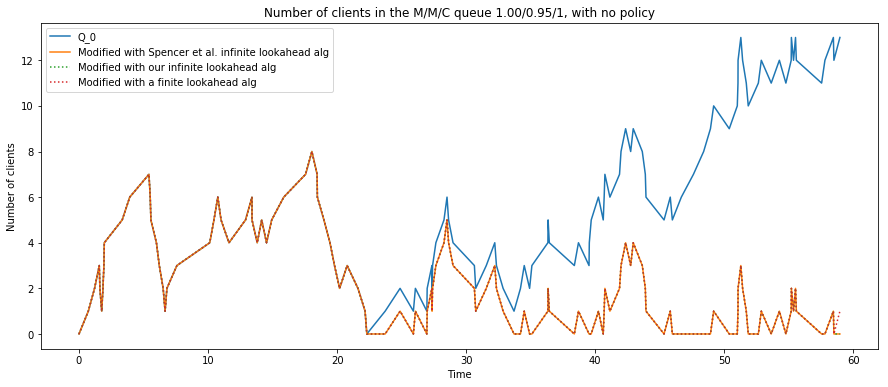

In [95]:
T1, N1, D1, _ = MM1Normal(arrivals, c, Tmax)
T4, N4, surge_prop = execute_deletions(T1, N1.copy())
deletions = gen_forward_deletions(T1.copy(), D1.copy(), 10000)
deletions2 = gen_forward_deletions_2(T1.copy(), D1.copy(), 10000)
deletions3 = gen_forward_deletions_2(T1.copy(), D1.copy(), 0.1)
modified = [max(0, i) for i in N1.copy() - deletions]
modified2 = [max(0, i) for i in N1.copy() - deletions2]
modified3 = [max(0, i) for i in N1.copy() - deletions3]
print("No Job Left Behind Surge Proportion %.2f" % (surge_prop))
start_index1 = int(len(T1)*start_prop)
end_index1 = int(len(T1)*end_prop)
figure(figsize=(15,6))
plot(T1[start_index1:end_index1], N1[start_index1:end_index1], label="Q_0")
plot(T4[start_index1:end_index1], N4[start_index1:end_index1], label="Modified with Spencer et al. infinite lookahead alg")
plot(T1[start_index1:end_index1], modified[start_index1:end_index1], label="Modified with our infinite lookahead alg", linestyle=":")
plot(T1[start_index1:end_index1], modified3[start_index1:end_index1], label="Modified with a finite lookahead alg", linestyle=":")
xlabel('Time')
ylabel('Number of clients')
legend()
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with no policy' % (lambd, mu1, c))

In [ ]:
'''T3, N3, _, use_surge = MM1WithWLookaheadConstant(arrivals, c, w, Tmax)

start_index3 = int(len(T3)*start_prop)
end_index3 = int(len(T3)*end_prop)
figure(figsize=(15,6))
#scatter(T3[start_index:end_index], N3[start_index:end_index])
plot(T3[start_index3:end_index3], N3[start_index3:end_index3])
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with w-lookahead online'
      % (lambd, mu1, c))
print("Use surge %.2f" % (use_surge))'''

In [ ]:
T2, N2, _, use_surge = MM1WithOneThreshold(arrivals, surge_threshold, c, Tmax)

start_index2 = int(len(T2)*start_prop)
end_index2 = int(len(T2)*end_prop)
figure(figsize=(15,6))
plot(T2[start_index2:end_index2], N2[start_index2:end_index2])
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with threshold %d'
      % (lambd, mu1, c, surge_threshold))
print("Use surge %.2f" % (use_surge))

In [ ]:
figure(figsize=(15,7))
plot(T1[start_index1:end_index1], N1[start_index1:end_index1], label="Q_0")
plot(T2[start_index2:end_index2], N2[start_index2:end_index2], label="after applying threshold=78")
#plot(T3[start_index3:end_index3], N3[start_index3:end_index3], label="after applying no job left behind")
plot(T4[start_index1:end_index1], N4[start_index1:end_index1], label="after applying no job left behind")
xlabel('Time')
ylabel('Number of clients')
legend()
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with different heuristics'
      % (lambd, mu1, c))

In [ ]:
'''##### SURGE count and proportion #####
            if T[-1] >= 1000 and T[-1] <= 9000:
                if in_surge == 0 and S == 0: # first time, mark t_temp
                    start_measuring_surge = T[-2]
                t_delta = T[-1] - popped_customer.enter_service_time
                S = S + (t_delta * N[-2])
                if popped_customer.fast:
                    in_surge = in_surge + t_delta
            if T[-1] > 9000:
                if end_measuring_surge == 0:
                    end_measuring_surge = T[-1]'''